<h4>Runtimes may vary. For this notebook a standard mac mini m2 with 16gb RAM was used</h4>

In [1]:
import dianna
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort

In [2]:
transform = transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [3]:
model_path = "./models/mnist_model.onnx" # an onnx model containing a cNN for the binary-mnist, classifying as 0 or 1 only
axis_labels = {0: 'channels'} # the color channels for the inputs have to be specified in order for dianna to work

In [4]:
# We will need the session to get the predictions later on for the DAUC-Metric. Dianna works by specifying the model path and abstracts away the instantiation of the session
# which is why we have to initiate one ourselves
session = ort.InferenceSession(model_path)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

 # Use the exponential function after the prediction to negate log-softmaxing. This allows us to interprete the results as a probability vector again
predict = lambda input_for_prediction: np.exp(session.run([output_name], {input_name: input_for_prediction}))

In [5]:
training_data_with_0_target_class = trainset.data[trainset.targets == 0]

In [6]:
first_zero = training_data_with_0_target_class[0]

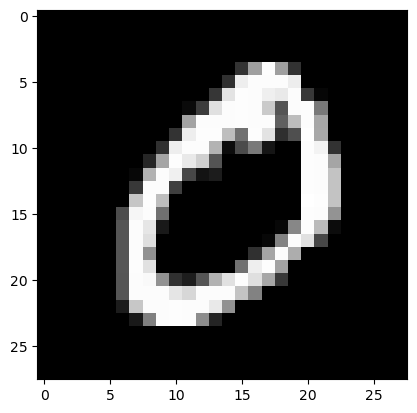

In [7]:
# Display the first zero as reference
plt.imshow(first_zero, cmap="grey")

------------------- START OF SECTION FOR RISE_PARAMETER_INITIALIZATION -------------

<h4>In this Section we generate multiple saliency maps with RISE to heuristically determine, which number of masks is viable in general</h4>
As RISE is computionally heavy, the parameter to_be_called is set to False. If (for whatever reason) you wish to run this method, please set the parameter to True in the following cell after the function definition

In [8]:
def generate_saliency_maps_for_rise_parameter_intialization(to_be_called:bool=False):
    """
    Generates a grid_picture for the first_zero consisting of saliency maps constructed with RISE.
    This method is used in the paper to visually approximate an upper bound for the number of 
    necessary masks.
    :param to_be_called: set this parameter to true, if you want to run this method. As the output will most likely stay 
                         the same, it does not make any sense to run this method yourself. Please refer to the generated image.
    :return: nothing, but the generated image can be found in the "intended_for_paper" directory
    """
    if not to_be_called:
        return
    
    fig, ax = plt.subplots(2, 3)
    num_of_masks=[[10**1, 10**2, 10**3], [10**4, 10**5, 10**6]]
    first_zero_input = first_zero.reshape(1, 28, 28).astype(np.float32)
    for i in range(2):
        current_masks = num_of_masks[i]
        for j in range(3):
            saliency_map_rise = dianna.explain_image(model_path, first_zero_input, method="RISE", labels=[0], n_masks=current_masks[j], axis_labels=axis_labels, p_keep=0.5)
            ax[i, j].set_title(f"Masks = {current_masks[j]}")
            ax[i, j].imshow(saliency_map_rise.reshape(28, 28))
            ax[i, j].imshow(first_zero.reshape(28, 28), cmap="grey", alpha=.3)
            ax[i, j].set_axis_off()
    plt.savefig("images/intended_for_paper/rise_n_masks.png")

In [9]:
generate_saliency_maps_for_rise_parameter_intialization(to_be_called=False)

------------------- END OF SECTION FOR RISE_PARAMETER_INITIALIZATION -------------

<h4>DAUC-Calculation Section</h4>
When generating the pictures, we are also interested in showcasing the DAUC metric. Unfortunately no package was found, that implements the DAUC directly, which is why we do that ourselves. 
We can delete the corresponding pixels by selecting the maxium values in the saliency map. We will gradually take the most yellow pixels, then replace them, run the model, to get the new confidence. We also want to draw 
the deleted regions in the picture output for reference.

In [10]:
from scipy.integrate import trapezoid

def calc_deletion_metric_and_return_image_with_deleted_areas_and_dauc(original_input, saliency_map):
    """
    Calculates the DAUC-Metric for the given input. The most important pixels are derived from the saliency map provided.
    :param original_input: the input on which the DAUC-Metric is inferred
    :param saliency_map: is used to determine the most important pixels, which are deleted from the original input
    :return: the dauc-score calculated along with the deleted image for reference
    """
    saliency_map_copy = np.copy(saliency_map).reshape(28, 28)
    original_input_copy = np.copy(original_input).reshape(28, 28)
    
    pixels_to_delete = 150
    
    outputs = []
    
    for _ in range(pixels_to_delete):
        min_value_to_replace_max_with = np.min(saliency_map_copy)
        saliency_map_max_value_x_index, saliency_map_max_value_y_index = np.unravel_index(np.argmax(saliency_map_copy), shape=(28, 28))
        saliency_map_copy[saliency_map_max_value_x_index][saliency_map_max_value_y_index] = min_value_to_replace_max_with
        original_input_copy[saliency_map_max_value_x_index][saliency_map_max_value_y_index] = 0
        
        predicted_output = predict(original_input_copy.reshape(1, 1, 28, 28))[0, 0, 0] # slicing to only get the output prob for the zero class
        
        outputs.append(predicted_output)
        
    outputs = np.asarray(outputs)
    deleted_area_under_curve = trapezoid(y=outputs, x=list(range(pixels_to_delete)))
    
    return original_input_copy, deleted_area_under_curve

<h4>Section: Good Explanations are not static. This Method will be used in the Main-Section</h4>

In [11]:
def calc_rise_saliency_map_and_save_as_image(image_deleted_areas, index, original_zero):
    """
    This method essentially runs RISE with the images containing the deleted areas and plots the confidence of the model as well.
    A high confidence of the model despite deleting the areas, indicates poor performance.
    :param image_deleted_areas: the image with the deleted areas, on which we run RISE with an increased number of masks.
    :param index: is just used for the names of the images saved
    :param original_zero: we use the original zero to overlay the images for reference and to calculate the original confidence of the model
    :return: nothing, but the generated images can be found in the saliency_maps_for_hypothesis_testing image folder
    """
    image_deleted_areas = image_deleted_areas.reshape(1, 1, 28, 28).astype(np.float32)
    prediction_deleted = predict(image_deleted_areas)[0, 0, 0] # only get zero prediction
    prediction_normal = predict(original_zero.reshape(1, 1, 28, 28).astype(np.float32))[0, 0, 0] # only get zero prediction
    image_deleted_saliency_map_rise = dianna.explain_image(model_path, image_deleted_areas.reshape(1, 28, 28), method="RISE", labels=[0], n_masks=5*10**3, axis_labels=axis_labels, p_keep=0.5)
    fix, ax = plt.subplots(1, 2)
    ax[0].set_title(f"Conf.: {prediction_normal:2f}")
    ax[0].imshow(original_zero.reshape(28, 28), cmap="grey")
    ax[0].set_axis_off()
    
    ax[1].set_title(f"Conf.: {prediction_deleted:.2f}")
    ax[1].imshow(image_deleted_saliency_map_rise.reshape(28, 28))
    ax[1].imshow(image_deleted_areas.reshape(28, 28), cmap="grey", alpha=.3)
    ax[1].set_axis_off()
    plt.savefig(f"images/saliency_maps_for_hypothesis_testing/{index+1}_zero_deleted_areas.png")
    plt.close()

<h4>The Main-Section. In this Section we generate the saliency maps</h4>

In [12]:
def save_heatmaps_side_by_side_with_original_as_png_file(index_as_filename:int, original_zero, 
                                                         rise_map, image_deleted_rise, dauc_rise, 
                                                         lime_map, image_deleted_lime, dauc_lime,
                                                         shap_map, image_deleted_shap, dauc_shap):
    """
    This method is used the plot the generated saliency maps side by side. We also plot the dauc values generated and the zeros 
    with the corresponding deleted regions for reference.
    :param index_as_filename: the index is only used for the filenames with which the images are stored
    :param original_zero: is used for reference only
    :param rise_map: saliency map provided with rise
    :param image_deleted_rise: the original zero but with the pixels deleted according the dauc-metric
    :param dauc_rise: the dauc values calculated
    :param lime_map: saliency map generated by LIME
    :param image_deleted_lime: the original zero but with the pixels deleted according the dauc-metric
    :param dauc_lime: the dauc values calculated
    :param shap_map: saliency map generated by KernelSHAP
    :param image_deleted_shap: the original zero but with the pixels deleted according the dauc-metric
    :param dauc_shap: the dauc values calculated
    :return: 
    """
    original_zero = original_zero.reshape(28, 28)
    rise_map = rise_map.reshape(28, 28)
    image_deleted_rise = image_deleted_rise.reshape(28, 28)
    lime_map = lime_map.reshape(28, 28)
    image_deleted_lime = image_deleted_lime.reshape(28, 28)
    shap_map = shap_map.reshape(28, 28)
    image_deleted_shap = image_deleted_shap.reshape(28, 28)
    
    fig, ax = plt.subplots(2, 4, figsize=(7, 4))
    ax[0, 0].set_title("Original Data")
    ax[0, 0].imshow(original_zero, cmap="grey")
    ax[0, 0].set_axis_off()
    
    ax[0, 1].set_title("RISE")
    ax[0, 1].imshow(rise_map)
    ax[0, 1].imshow(original_zero, alpha=.3)
    ax[0, 1].set_axis_off()
    
    ax[1, 0].axis('off')
    
    ax[1, 1].imshow(image_deleted_rise, cmap="grey")
    ax[1, 1].set_axis_off()
    ax[1, 1].set_title(f"DAUC = {dauc_rise:.2f}")
    
    ax[0, 2].set_title("LIME")
    ax[0, 2].imshow(lime_map)
    ax[0, 2].imshow(original_zero, alpha=.3)
    ax[0, 2].set_axis_off()
    
    ax[1, 2].imshow(image_deleted_lime, cmap="grey")
    ax[1, 2].set_title(f"DAUC = {dauc_lime:.2f}")
    ax[1, 2].set_axis_off()
    
    ax[0, 3].set_title("KernelSHAP")
    ax[0, 3].imshow(shap_map)
    ax[0, 3].imshow(original_zero, alpha=.3)
    ax[0, 3].set_axis_off()
    
    ax[1, 3].imshow(image_deleted_shap, cmap="grey")
    ax[1, 3].set_title(f"DAUC = {dauc_shap:.2f}")
    ax[1, 3].set_axis_off()
    
    plt.savefig(f"images/saliency_maps/{index_as_filename + 1}_zero.png")
    plt.close()
    #plt.show()

In [13]:
normalize_input_img = lambda img: (img / 255).astype(np.float32) # Is used for the preprocessing in the case of LIME. RISE and SHAP are not dependent on the preprocessing-process

def run_all_explainibility_methods_on_first_k_inputs_and_generate_mean_saliency_maps(k_first_samples: int):
    """
    This is the main method in which we generate the saliency-maps with RISE, LIME and KernelSHAP.
    :param k_first_samples: The first k entries for which we would like to generate the saliency maps
    :return: 3 lists, containing the dauc values calulcated for each method. Furthermore the plotted saliencymaps are available in the saliency_maps folder
    """
    daucs_rise, daucs_lime, daucs_shap = [], [], []
    for i in range(k_first_samples):
            zero = training_data_with_0_target_class[i]
            zero = zero.numpy().reshape(1, 28, 28).astype(np.float32)
            
            # RISE
            saliency_map_rise = dianna.explain_image(model_path, zero, method="RISE", labels=[0], n_masks=10**4, axis_labels=axis_labels, p_keep=0.5)
            image_deleted_ares_rise, dauc_rise = calc_deletion_metric_and_return_image_with_deleted_areas_and_dauc(zero, saliency_map_rise)
            daucs_rise.append(dauc_rise)
            
            # Theoretical Supremum is 150 (despite deleting pixels, the confidence does not change). A value of 100 indicates that the model was still confident on the input being a zero on average.
            # With RISE highlighting the lateral symmetry, we will likely see deleted horizontal sides but still a high confidence
            if dauc_rise <= 100:
                calc_rise_saliency_map_and_save_as_image(image_deleted_ares_rise, i, zero)
            
            # LIME
            saliency_map_lime = dianna.explain_image(model_path, zero, method="LIME", labels=[0, 1], axis_labels=axis_labels, num_features=100, num_samples=10000, preprocess_function=normalize_input_img)[0]
            image_deleted_areas_lime, dauc_lime = calc_deletion_metric_and_return_image_with_deleted_areas_and_dauc(zero, saliency_map_lime)
            daucs_lime.append(dauc_lime)
            
            # SHAP
            saliency_map_shap = dianna.explain_image(model_path, zero, method="KernelSHAP", axis_labels=axis_labels, labels=[0], background=0, nsamples=10000, n_segments=200)[0]
            image_deleted_ares_shap, dauc_shap = calc_deletion_metric_and_return_image_with_deleted_areas_and_dauc(zero, saliency_map_shap)
            daucs_shap.append(dauc_shap)
        
            save_heatmaps_side_by_side_with_original_as_png_file(i, zero, 
                                                                 saliency_map_rise, image_deleted_ares_rise, dauc_rise,
                                                                 saliency_map_lime, image_deleted_areas_lime, dauc_lime,
                                                                 saliency_map_shap, image_deleted_ares_shap, dauc_shap)
    return daucs_rise, daucs_lime, daucs_shap    

<h4>Approximate Runtime of this cell: 45 Minutes</h4>

In [14]:
%%capture
# We supress the output of this cell with the capture-call, because the output will get very long as each method uses a progress bar to indicate progress
k_first_samples = 100
daucs_rise, daucs_lime, daucs_shap = run_all_explainibility_methods_on_first_k_inputs_and_generate_mean_saliency_maps(k_first_samples) # The one is just for showcase, for the 100 images, the parameter was a 100 of course

2024-07-07 12:54:53.699222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9
2024-07-07 12:54:53.819837: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9
2024-07-07 12:54:56.603669: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9
2024-07-07 12:55:13.348615: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard/branch_executed/_9
2024-07-07 12:55:13.466046: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: assert_equal_1/Assert/AssertGuard

In [15]:
mean_dauc_rise = np.sum(daucs_rise) / k_first_samples
mean_dauc_lime = np.sum(daucs_lime) / k_first_samples
mean_daus_shap = np.sum(daucs_shap) / k_first_samples

In [16]:
print(f"Mean DAUC of RISE = {mean_dauc_rise}")
print(f"Mean DAUC of LIME = {mean_dauc_lime}")
print(f"Mean DAUC of SHAP = {mean_daus_shap}")


"""
# Output of mean values in last run
Mean DAUC of RISE = 113.22977137638897
Mean DAUC of LIME = 147.55649903565646
Mean DAUC of SHAP = 148.94185312092304
"""

Mean DAUC of RISE = 113.0477071053006
Mean DAUC of LIME = 146.66033105507492
Mean DAUC of SHAP = 148.95736768960953


'\n# Output of mean values in last run\nMean DAUC of RISE = 113.22977137638897\nMean DAUC of LIME = 147.55649903565646\nMean DAUC of SHAP = 148.94185312092304\n'

According to the mean dauc, the RISE method performs better more often. We will focus on the saliency maps generated by rise, to derive features of a good explanation, for the zero classification.
Generally, the highlighted regions of RISE contain both side of the zero, with visually the same importance. However, there seem to be some zeros, where the sides dont seem to be equally important. 
We will create a list of indices, to rerun RISE with those zeros, but with a higher number of masks than 10^4. If both sides then are equally important, the random mask generation is at fault. But if it stays 
the same, i.e the sides are still note equally important, it is more likely, that we have to different groups of zeros at hand.

<h4>Hypothesis-Section: Asymmetrical Classes of Zero are likely to exist. Approximate Runtime of this cell ~ 1 hour, which is why only run this method only, if the user explicitly wished to do so.
Results probabaly will not vary much anyway, due to the high number of masks.</h4>

In [17]:
def rerun_rise_with_50_000_masks_to_increase_likelihood_of_asymmetrical_masks(to_be_called:bool=False):
    """
    As it could be the case, that the zeros with asymmetrical lateral importance, are due to not having both sides equally covered, we rerun RISE on those inputs, 
    but with a higher number of masks (50.000), to increase the odds, of having at least 2 classes in our zeros, those with equal lateral importance and those 
    with unequal lateral importance
    :param to_be_called: set this parameter to true, if you want to run this function, in the following cell
    :return: nothing, but the generated images can be found in the "rise_asymmetrical_tests" directoy
    """
    if not to_be_called:
        return 
    
    # These numbers were derived from the saliency_maps image folder, where the sides do not seem to be equally important
    indices = [
        7, 8, 10, 11, 14, 26, 29, 31, 39, 40, 44, 47, 48, 49, 51, 53, 54, 59, 66, 68, 69, 71, 72, 73, 74, 75, 77, 78, 81, 82, 83, 85, 86, 88, 90, 93, 94, 95, 96, 97, 99
    ]
    
    for index in indices:
        zero = training_data_with_0_target_class[index - 1]
        zero = zero.numpy().reshape(1, 28, 28).astype(np.float32)
        saliency_map_rise = dianna.explain_image(model_path, zero, method="RISE", labels=[0], n_masks=5*10**4, axis_labels=axis_labels, p_keep=0.5)
        plt.subplot(1, 1, 1)
        plt.title("RISE")
        plt.imshow(saliency_map_rise.reshape(28, 28))
        plt.imshow(zero.reshape(28, 28), alpha=.3, cmap="grey")
        plt.axis('off')
        plt.savefig(f"images/rise_asymmetrical_tests/{index}_rise_asymmetrical_zero_test.png")
        plt.close()

In [18]:
rerun_rise_with_50_000_masks_to_increase_likelihood_of_asymmetrical_masks(to_be_called=True)

Explaining: 100%|██████████| 50000/50000 [01:15<00:00, 665.13it/s]
